In [1]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
RANDOM_STATE = 33

In [3]:
df = pd.read_csv('../data/preprocessed_data.csv') 

In [4]:
label = df['HeartDisease']
data = df.drop('HeartDisease', axis=1) 

In [5]:
# Function to print out metrics for each experiment

def get_metrics(true_labels, predictions):
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions) 
    print(f"Accuracy: {accuracy} \nF1: {f1} \nPrecision: {precision} \nRecall: {recall}") 

## Base KNN Model with all features

In [6]:
X_train_all, X_test_all, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=RANDOM_STATE) 

In [7]:
knnmodel_all = KNeighborsClassifier() #using default of 5 for now 
knnmodel_all.fit(X_train_all, y_train)  

KNeighborsClassifier()

In [8]:
y_pred = knnmodel_all.predict(X_test_all)
get_metrics(y_test, y_pred) 

Accuracy: 0.842391304347826 
F1: 0.867579908675799 
Precision: 0.8715596330275229 
Recall: 0.8636363636363636


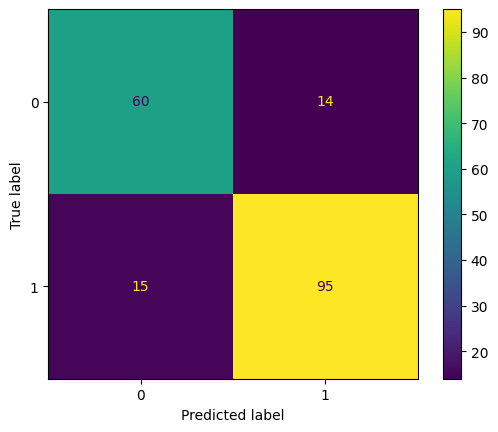

In [9]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot() 

## Grid Search on all features 

In [10]:
param_grid = {'n_neighbors': [2, 3, 5, 10, 15, 20, 50],
              'metric': ['euclidean', 'manhattan', 'minkowski']} # Default is minkowski. 

In [11]:
gridsearch = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid)
gridsearch.fit(X_train_all, y_train) 

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [2, 3, 5, 10, 15, 20, 50]})

In [12]:
gridsearch.best_params_ 

{'metric': 'manhattan', 'n_neighbors': 10}

In [13]:
knnmodel_grid = gridsearch.best_estimator_
y_pred = knnmodel_grid.predict(X_test_all) 

In [14]:
y_pred = knnmodel_grid.predict(X_test_all)
get_metrics(y_test, y_pred) 

Accuracy: 0.8478260869565217 
F1: 0.8679245283018868 
Precision: 0.9019607843137255 
Recall: 0.8363636363636363


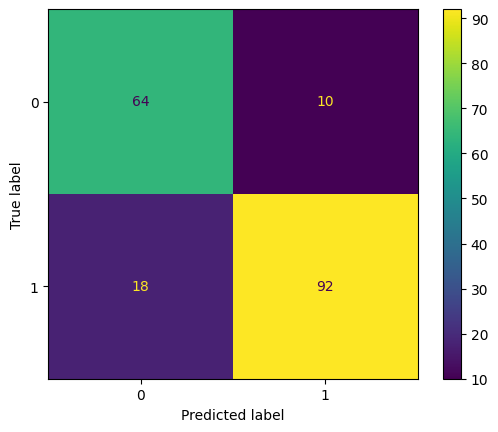

In [15]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

## Using only highly correlated features

In [16]:
#correlation is calculated here to extract features with high correlation
correlation = df.corr()['HeartDisease'].sort_values(ascending=False)

#features with correlation higher than 0.25 with heart disease is done
high_corr_features = correlation[abs(correlation) > 0.25].index.tolist()
high_corr_features.remove('HeartDisease')

In [17]:
# feature matrix for X and Y is selected here
X = df[high_corr_features]
y = df['HeartDisease'] 

In [18]:
X_train_corr, X_test_corr, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
knnmodel = KNeighborsClassifier() #using default of 5 for now 
knnmodel.fit(X_train_corr, y_train)  

KNeighborsClassifier()

In [19]:
y_pred = knnmodel.predict(X_test_corr) 
get_metrics(y_test, y_pred) 

Accuracy: 0.842391304347826 
F1: 0.863849765258216 
Precision: 0.8932038834951457 
Recall: 0.8363636363636363


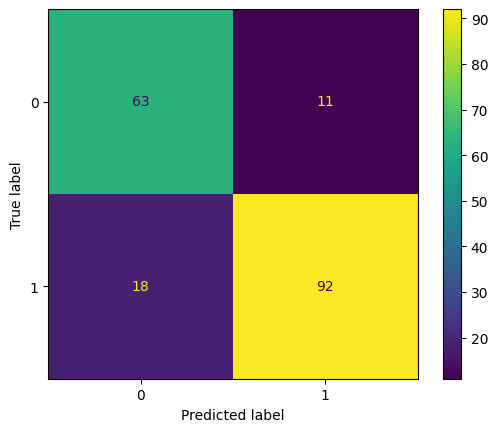

In [20]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

Using highly correlated features results in a better performance.

## Try out PCA

If n_components == 'mle' and svd_solver == 'full', Minka’s MLE is used to guess the dimension. Use of n_components == 'mle' will interpret svd_solver == 'auto' as svd_solver == 'full'.

In [21]:
pca = PCA(n_components='mle', random_state=RANDOM_STATE) 

In [22]:
X_train_reduced = pca.fit_transform(X_train_all)
X_test_reduced = pca.transform(X_test_all) 

In [23]:
X_train_reduced.shape, X_test_reduced.shape

((734, 15), (184, 15))

In [24]:
knnmodel.fit(X_train_reduced, y_train) 

KNeighborsClassifier()

In [25]:
y_pred = knnmodel.predict(X_test_reduced) 
get_metrics(y_test, y_pred)

Accuracy: 0.842391304347826 
F1: 0.867579908675799 
Precision: 0.8715596330275229 
Recall: 0.8636363636363636


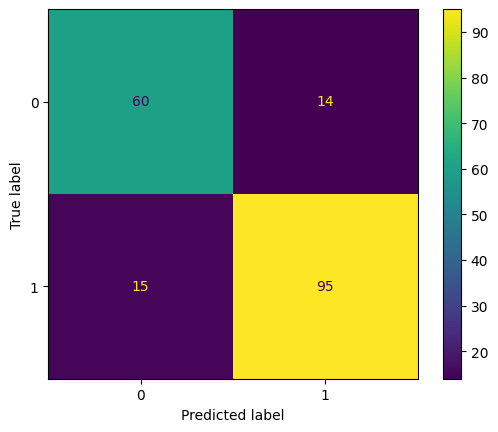

In [26]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

## Backward Feature Selector

In [27]:
from sklearn.feature_selection import SequentialFeatureSelector

In [28]:
knnmodel = KNeighborsClassifier()
sfs = SequentialFeatureSelector(estimator=knnmodel, direction='backward')
sfs.fit(X_train_all, y_train) 

SequentialFeatureSelector(direction='backward',
                          estimator=KNeighborsClassifier())

In [29]:
cols = X_train_all.columns[sfs.support_] 
cols

Index(['scaled_Cholesterol', 'scaled_Oldpeak', 'Sex_F', 'Sex_M',
       'ChestPainType_ASY', 'ExerciseAngina_N', 'ExerciseAngina_Y',
       'ST_Slope_Flat', 'ST_Slope_Up', 'RestingECG_LVH', 'RestingECG_ST'],
      dtype='object')

In [30]:
data.columns

Index(['scaled_Age', 'scaled_RestingBP', 'scaled_Cholesterol', 'scaled_MaxHR',
       'scaled_Oldpeak', 'FastingBS_0', 'FastingBS_1', 'Sex_F', 'Sex_M',
       'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP',
       'ChestPainType_TA', 'ExerciseAngina_N', 'ExerciseAngina_Y',
       'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up', 'RestingECG_LVH',
       'RestingECG_Normal', 'RestingECG_ST'],
      dtype='object')

In [31]:
knnmodel.fit(X_train_all[cols], y_train) 

KNeighborsClassifier()

In [32]:
y_pred = knnmodel.predict(X_test_all[cols]) 
get_metrics(y_test, y_pred) 

Accuracy: 0.8586956521739131 
F1: 0.8796296296296297 
Precision: 0.8962264150943396 
Recall: 0.8636363636363636


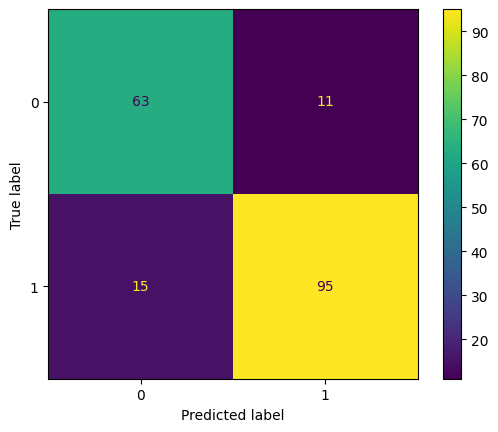

In [33]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot() 

## Tuning the threshold for the best model, and generating metrics accordingly.

In [36]:
pred_probs = knnmodel.predict_proba(X_test_all[cols])

In [42]:
def get_preds(pred_probs, threshold):
    return np.where(pred_probs>=threshold, 1, 0)[:, 1] #Get predictions for class '1'

In [54]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5] 

In [60]:
threshold_dict = {}
for threshold in thresholds:
    threshold_dict[f'threshold_{threshold}'] = get_preds(pred_probs, threshold)


In [62]:
threshold_dict.keys()

dict_keys(['threshold_0.1', 'threshold_0.2', 'threshold_0.3', 'threshold_0.4', 'threshold_0.5'])

In [64]:
for pred in threshold_dict.keys():
    print(f"\nAt {pred}")
    get_metrics(y_test, threshold_dict[pred])


At threshold_0.1
Accuracy: 0.7880434782608695 
F1: 0.8395061728395061 
Precision: 0.7669172932330827 
Recall: 0.9272727272727272

At threshold_0.2
Accuracy: 0.7880434782608695 
F1: 0.8395061728395061 
Precision: 0.7669172932330827 
Recall: 0.9272727272727272

At threshold_0.3
Accuracy: 0.8369565217391305 
F1: 0.8672566371681416 
Precision: 0.8448275862068966 
Recall: 0.8909090909090909

At threshold_0.4
Accuracy: 0.8369565217391305 
F1: 0.8672566371681416 
Precision: 0.8448275862068966 
Recall: 0.8909090909090909

At threshold_0.5
Accuracy: 0.8586956521739131 
F1: 0.8796296296296297 
Precision: 0.8962264150943396 
Recall: 0.8636363636363636


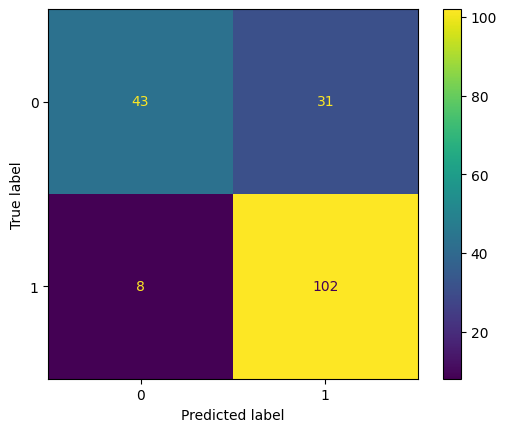

In [65]:
ConfusionMatrixDisplay(confusion_matrix(y_test, threshold_dict['threshold_0.2'])).plot() 

The most reasonable recall was at a threshold of 0.2 - this resulted in only 8 false negatives. However, there were 31 false positives while using this threshold. The threshold can be tuned based on what is required - we just wanted to try it out.